### Step 1: Install required packages

In [ ]:
# Make sure to install yfinance, pandas, numpy, scipy, and matplotlib:
# pip install yfinance pandas numpy scipy matplotlib

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime
from dateutil.relativedelta import relativedelta
import ast
import json

### Step 2: Fetch historical data using YahooFinance API

In [45]:
def fetch_data(stock_list, start_date, end_date):
    stock_data = yf.download(stock_list, start=start_date, end=end_date)['Adj Close']
    return stock_data

def fetch_price_data(stock_list, start_date, end_date):
    #################################
    if isinstance(start_date,datetime.datetime):
        start_date = start_date
    else:
        start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    #################################
    if isinstance(end_date,datetime.datetime):
        end_date = end_date
    else:
        end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    ##################################
    start_date = start_date - relativedelta(years=3)
    end_date   = end_date + relativedelta(days=10)
    stock_data = yf.download(stock_list, start=start_date, end=end_date)['Adj Close']
    return stock_data

# Step 3: Define optimization functions
def calc_portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculates the performance (return and standard deviation) of a portfolio given the weights, mean returns, and covariance matrix.
    """
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    """
    Optimizes the portfolio by maximizing the Sharpe ratio.
    """
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        p_var, p_ret = calc_portfolio_performance(weights, mean_returns, cov_matrix)
        return -(p_ret - risk_free_rate) / p_var

    result = minimize(neg_sharpe_ratio, num_assets * [1. / num_assets,], args=args,
                      bounds=bounds, constraints=constraints)
    return result['x']

def minimize_variance(mean_returns, cov_matrix):
    """
    Optimizes the portfolio by minimizing the variance.
    """
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    def portfolio_variance(weights, mean_returns, cov_matrix):
        return calc_portfolio_performance(weights, mean_returns, cov_matrix)[0]

    result = minimize(portfolio_variance, num_assets * [1. / num_assets,], args=args,
                      bounds=bounds, constraints=constraints)
    return result['x']

In [ ]:
stock_list = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
risk_free_rate = 0.1
start_date = "2019-01-01"
end_date = "2021-12-31"
rebal_freq = "M"
risk_free_rate = 0.02

# Fetch stock data
stock_data = fetch_data(stock_list, start_date, end_date)[stock_list]

# Create a copy for use in calculation
price_data = fetch_price_data(stock_list, start_date, end_date)[stock_list]

# Resample frame
stock_data = stock_data.resample("D").last().fillna(method="ffill").fillna(method="bfill")

### Step 3: Create functions to get portfolio weights

In [ ]:
def get_weights_port_optimize(price_data, stock_list, trade_date, risk_free_rate=0.1):
    """
    Takes price data, stock list, trade date, and risk-free rate as inputs, and \
    returns the optimized weights for each strategy (maximize Sharpe ratio, minimize variance, equal-weighted) and current prices.
    """
    # Set dates
    if isinstance(trade_date,datetime.datetime):
        end_date = trade_date
    else:
        end_date = datetime.datetime.strptime(trade_date, '%Y-%m-%d')
    start_date = end_date - relativedelta(years=3)

    # Fetch stock data
    price_data2 = price_data.loc[start_date:end_date+ relativedelta(days=1)]
    #stock_data = fetch_data(stock_list, start_date, end_date)[stock_list]
    
    # Get current actual trade date price
    current_price = price_data.loc[start_date:end_date + relativedelta(days=10)]
    #current_price = fetch_data(stock_list, start_date, end_date + relativedelta(days=7))[stock_list]
    current_price = current_price.iloc[current_price.index.get_loc(end_date,method="bfill")]
    
    # Resample frame
    price_data2 = price_data2.resample('D').last().fillna(method="ffill").fillna(method="bfill")
    stock_returns = price_data2.pct_change().dropna()

    # Calculate mean returns and covariance matrix
    mean_returns = stock_returns.mean()
    cov_matrix = stock_returns.cov()

    # Calculate optimal weights for each strategy
    weights_msr = maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    weights_minv = minimize_variance(mean_returns, cov_matrix)
    weights_eqw = np.full(stock_returns.shape[1], 1 / stock_returns.shape[1])

    return [weights_msr, weights_minv, weights_eqw, 
            current_price.values]

### Step 4: Loop through rebalance dates and get new weights at rebalance period. 

In [39]:
rebal_period = stock_data.index.tolist()[:1] + stock_data.resample(rebal_freq).last().index.tolist()
rebal_frame = pd.DataFrame([get_weights_port_optimize(price_data, stock_list,x,risk_free_rate) for x in rebal_period],
                           index=rebal_period).apply(pd.Series)
rebal_frame.columns = ["weights_msr", "weights_minv", "weights_eqw", "last_rebal_price"]

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


C:\Users\patel\AppData\Local\Temp\ipykernel_20120\2002072272.py:85: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  current_price = current_price.iloc[current_price.index.get_loc(end_date,method="bfill")]


### Step 5: Calculate investment value at each rebalance period

In [40]:
rebal_frame[["shares_msr","shares_minv","shares_eqw",
             "cash_msr","cash_minv","cash_eqw",
             "inv_msr","inv_minv","inv_eqw",
             "tinv_msr","tinv_minv","tinv_eqw"]] = np.NaN

rebal_count = 0
cash_msr, cash_minv, cash_eqw = 5000,5000,5000
for i in rebal_frame.index:
    # Fetch weights and trade price
    weights_msr,weights_minv,weights_eqw,last_rebal_price = rebal_frame.loc[i,["weights_msr","weights_minv","weights_eqw","last_rebal_price"]]
    
    # Sell shares from the last rebalance and get cash to buy the new rebalance
    if rebal_count != 0:
        cash_msr, cash_minv, cash_eqw = rebal_frame.iloc[rebal_count-1][["cash_msr", "cash_minv", "cash_eqw"]]
        shares_msr, shares_minv, shares_eqw = rebal_frame.iloc[rebal_count-1][["shares_msr", "shares_minv", "shares_eqw"]]
        shares_msr, shares_minv, shares_eqw = np.array(json.loads(shares_msr)),np.array(json.loads(shares_minv)),np.array(json.loads(shares_eqw))
        # Reduce 0.3% of the sold shares as transaction costs 
        transaction_cost = 0.03
        cash_msr = (1-transaction_cost)*(np.multiply(shares_msr,last_rebal_price).sum()) + cash_msr
        cash_minv = (1-transaction_cost)*(np.multiply(shares_minv,last_rebal_price).sum()) + cash_minv
        cash_eqw = (1-transaction_cost)*(np.multiply(shares_eqw,last_rebal_price).sum()) + cash_eqw
    
    # Weights in shares
    rebal_frame.loc[i,"shares_msr"] = json.dumps(np.array(np.divide(pd.Series(cash_msr*weights_msr),last_rebal_price)//1).tolist()) # rounding down
    rebal_frame.loc[i,"shares_minv"] = json.dumps(np.array(np.divide(pd.Series(cash_minv*weights_minv),last_rebal_price)//1).tolist()) # rounding down
    rebal_frame.loc[i,"shares_eqw"] = json.dumps(np.array(np.divide(pd.Series(cash_eqw*weights_eqw),last_rebal_price)//1).tolist())

    # Weights in shares, decimal
    rebal_frame.loc[i,"shares_msr2"] = json.dumps(np.array(np.divide(pd.Series(cash_msr*weights_msr),last_rebal_price)).tolist())
    rebal_frame.loc[i,"shares_minv2"] = json.dumps(np.array(np.divide(pd.Series(cash_minv*weights_minv),last_rebal_price)).tolist())
    rebal_frame.loc[i,"shares_eqw2"] = json.dumps(np.array(np.divide(pd.Series(cash_eqw*weights_eqw),last_rebal_price)).tolist())

    # Investment vale
    rebal_frame.loc[i,"inv_msr"] = np.multiply(np.array(json.loads(rebal_frame.loc[i,"shares_msr"])),last_rebal_price).sum()
    rebal_frame.loc[i,"inv_minv"] = np.multiply(np.array(json.loads(rebal_frame.loc[i,"shares_minv"])),last_rebal_price).sum()
    rebal_frame.loc[i,"inv_eqw"] = np.multiply(np.array(json.loads(rebal_frame.loc[i,"shares_eqw"])),last_rebal_price).sum()

    # Remaining cash
    rebal_frame.loc[i,"cash_msr"] = cash_msr - rebal_frame.loc[i,"inv_msr"]
    rebal_frame.loc[i,"cash_minv"] = cash_minv - rebal_frame.loc[i,"inv_minv"]
    rebal_frame.loc[i,"cash_eqw"] = cash_eqw - rebal_frame.loc[i,"inv_eqw"]

    # Total amount
    rebal_frame.loc[i,"tinv_msr"] = rebal_frame.loc[i,"cash_msr"] + rebal_frame.loc[i,"inv_msr"]
    rebal_frame.loc[i,"tinv_minv"] = rebal_frame.loc[i,"cash_minv"] + rebal_frame.loc[i,"inv_minv"]
    rebal_frame.loc[i,"tinv_eqw"] = rebal_frame.loc[i,"cash_eqw"] + rebal_frame.loc[i,"inv_eqw"]

    rebal_count+=1

### Step 6: Join with daily prices and calculate daily investment position for the selected period

In [42]:
# Join on rebalance dates the wieghts and total investment value
stock_data = stock_data.join(rebal_frame,how="left")

# Fill forward the necessary column
stock_data[['weights_msr','weights_minv','weights_eqw','last_rebal_price', 
            'shares_msr', 'shares_minv','shares_eqw', 
            'cash_msr', 'cash_minv', 'cash_eqw', 
            'shares_msr2', 'shares_minv2', 'shares_eqw2']] = stock_data[['weights_msr','weights_minv','weights_eqw','last_rebal_price', 
                                                                         'shares_msr', 'shares_minv','shares_eqw', 
                                                                         'cash_msr', 'cash_minv', 'cash_eqw', 
                                                                         'shares_msr2', 'shares_minv2', 'shares_eqw2']].fillna(method="ffill")

# Create decimal investment value
stock_data[["tinv_msr2","tinv_minv2","tinv_eqw2"]] = np.NaN

# Function to calculate decimal invested amount
def calulate_decimal_investment(x):
    # Get price
    price_array = x[stock_list]
    # Get shareholding weight
    shares_msr = np.array(json.loads(x["shares_msr2"]))
    shares_minv = np.array(json.loads(x["shares_minv2"]))
    shares_eqw = np.array(json.loads(x["shares_eqw2"]))
    # Get invested amount
    inv_msr = np.multiply(price_array,shares_msr).sum()
    inv_minv = np.multiply(price_array,shares_minv).sum()
    inv_eqw = np.multiply(price_array,shares_eqw).sum()
    # Return investment
    return inv_msr, inv_minv, inv_eqw

# Function to calculate normal invested amount
def calulate_normal_investment(x):
    # Get price
    price_array = np.array(x[stock_list])
    # Get shareholding weight
    shares_msr = np.array(json.loads(x["shares_msr"]))
    shares_minv = np.array(json.loads(x["shares_minv"]))
    shares_eqw = np.array(json.loads(x["shares_eqw"]))
    # Get invested amount
    if np.isnan(x["tinv_msr"]):
        inv_msr = np.multiply(price_array,shares_msr).sum() + x["cash_msr"]
        inv_minv = np.multiply(price_array,shares_minv).sum() + x["cash_minv"]
        inv_eqw = np.multiply(price_array,shares_eqw).sum() + x["cash_eqw"]
    else:
        inv_msr = x["inv_msr"] + x["cash_msr"]
        inv_minv = x["inv_minv"] + x["cash_minv"]
        inv_eqw = x["inv_eqw"] + x["cash_eqw"]
    # Return investment
    return inv_msr, inv_minv, inv_eqw

# Get total decimal investment
stock_data[["tinv_msr2","tinv_minv2","tinv_eqw2"]] = stock_data.apply(calulate_decimal_investment, axis=1).apply(pd.Series)

# Get the invested amount if invested in shares without fractions
stock_data[["tinv_msr","tinv_minv","tinv_eqw"]] = stock_data.apply(calulate_normal_investment, axis=1).apply(pd.Series)

### Step 7: Plot strategies to view performance of the strategies

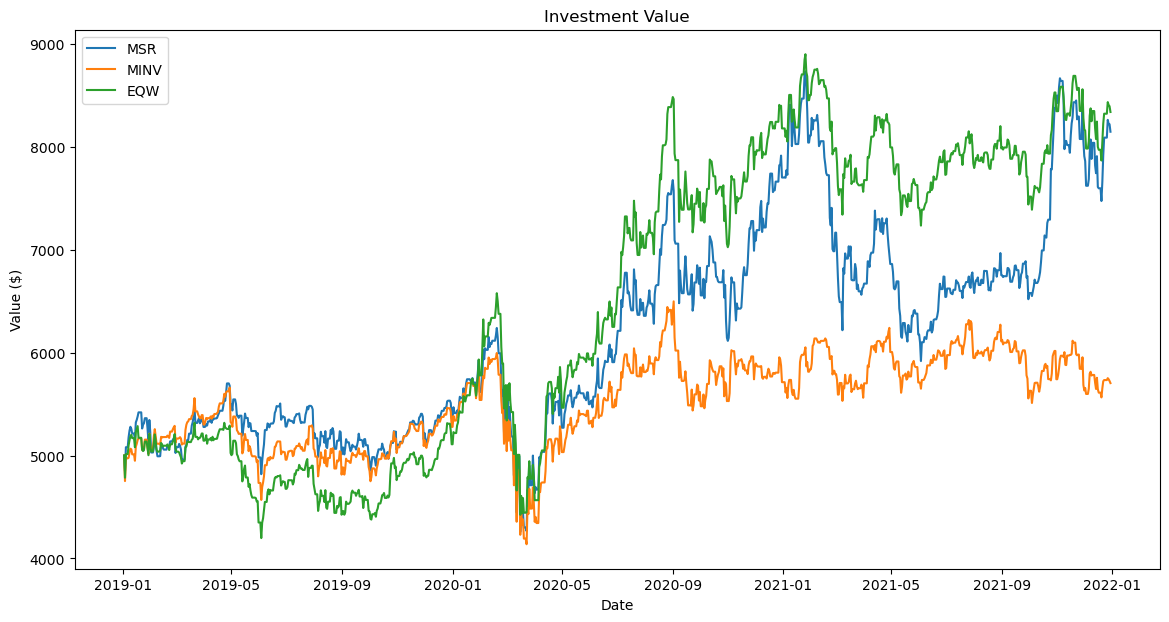

In [43]:
def plot_results(investment_value_msr, investment_value_minv, investment_value_eqw):
    plt.figure(figsize=(14, 7))
    plt.plot(investment_value_msr, label="MSR")
    plt.plot(investment_value_minv, label="MINV")
    plt.plot(investment_value_eqw, label="EQW")
    plt.title("Investment Value")
    plt.xlabel("Date")
    plt.ylabel("Value ($)")
    plt.legend()
    plt.show()

plot_results(stock_data["tinv_msr"], stock_data["tinv_minv"], stock_data["tinv_eqw"])


### Step 8: Calculate performance metrics

In [ ]:
def annual_sharpe_ratio(daily_returns):
    """
    Takes in daily returns of the portfolio and provides the annualized sharpe ratio.
    daily_returns: input pd.Series which contains daily returns of the portfolio
    """
    sharpe_ratio = (252**0.5)*(daily_returns.mean()/daily_returns.std())
    return sharpe_ratio

def annual_metric(daily_returns):
    """
    Calculates the annualized return and variation for a portfolio given daily returns.
    """
    # Calculate annualized return
    annualized_return = daily_returns.sum()
    # Calculate annualized variation
    annualized_variation = daily_returns.std() * np.sqrt(252)
    return annualized_return, annualized_variation

In [44]:
port_return, port_variance = annual_metric(stock_data["tinv_msr"].pct_change().dropna())
port_sharpe  = annual_sharpe_ratio(stock_data["tinv_msr"].pct_change().dropna())

print ("Maximize Sharpe ratio:", 
        "\nSharpe ratio: ", port_sharpe,
        "\nReturn: ", port_return, 
        "\nVariance: ", port_variance, "\n")

port_return, port_variance = annual_metric(stock_data["tinv_minv"].pct_change().dropna())
port_sharpe  = annual_sharpe_ratio(stock_data["tinv_minv"].pct_change().dropna())

print ("Minimize variance:", 
        "\nSharpe ratio: ", port_sharpe,
        "\nReturn: ", port_return, 
        "\nVariance: ", port_variance, "\n")

port_return, port_variance = annual_metric(stock_data["tinv_eqw"].pct_change().dropna())
port_sharpe  = annual_sharpe_ratio(stock_data["tinv_eqw"].pct_change().dropna())

print ("Equal weighted:", 
        "\nSharpe ratio: ", port_sharpe,
        "\nReturn: ", port_return, 
        "\nVariance: ", port_variance, "\n")

Maximize Sharpe ratio: 
Sharpe ratio:  0.5339720190464157 
Return:  0.6714806988695227 
Variance:  0.2899315068365569 

Minimize variance: 
Sharpe ratio:  0.24718336654649287 
Return:  0.2615334428325218 
Variance:  0.24394300360399865 

Equal weighted: 
Sharpe ratio:  0.5924047487637772 
Return:  0.6523532284091547 
Variance:  0.2538894551658325 

